In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

In [3]:
from matplotlib import pyplot as plt

In [4]:
cuda_driver.init()

In [5]:
cuda_device = cuda_driver.Device(0)

In [6]:
print("Using {:s}".format(cuda_device.name() ))

Using Tesla P100-PCIE-12GB


# My first GPU program
I will not find $\pi$ today.

In [7]:
context = cuda_device.make_context()

In [8]:
free, total = cuda_driver.mem_get_info()
print("Memory is {:d} / {:d}".format(free, total))

Memory is 11445600256 / 12790923264


In [9]:
cuda_kernel = """
__global__ void addKernel(double* c, double* a, double* b, int cols, int rows) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    int k = i + j*cols;
    if (i <cols && j<rows){
        c[k] = a[k] + b[k];
    }
}
"""

In [10]:
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addKernel")

In [11]:
#?np.random.rand

In [12]:
nx = 50
ny = 25
a = np.random.rand(ny,nx).astype(np.float64)
b = np.random.rand(ny,nx).astype(np.float64)
c = np.empty_like(a)

In [13]:
a_gpu = GPUArray(a.shape, np.float64)
a_gpu.set(a)

In [14]:
b_gpu = GPUArray(b.shape, np.float64)
b_gpu.set(b)

In [15]:
c_gpu = GPUArray(c.shape, np.float64)

// er int-divisjon

In [16]:
#block_x = 8
#block_y = 4

block = (8,4,1)
domain = (nx, ny, 1)
grid = ((nx+7)//8, ((ny+3)//4), 1)

print(domain)
print(block)
print(grid)

(50, 25, 1)
(8, 4, 1)
(7, 7, 1)


In [17]:
kernel(c_gpu, a_gpu, b_gpu, np.int32(nx), np.int32(ny), block=block, grid=grid)

TODO: gjør om block og grid til matrise i stedet for array

In [18]:
#kernel(c_gpu, a_gpu, b_gpu, block=(n, 1, 1), grid=(1,1,1))

In [19]:
c_gpu.get(c)

array([[1.0736862 , 0.62807958, 1.49226254, ..., 1.39136255, 1.29945007,
        0.40518129],
       [0.82283753, 1.67340828, 1.39499866, ..., 1.04182313, 0.19277944,
        0.89503527],
       [0.85541324, 1.06408626, 0.49609032, ..., 1.10879344, 1.13498449,
        1.16799553],
       ...,
       [1.23699884, 0.83274091, 0.61966772, ..., 1.49202753, 1.5207153 ,
        0.85524214],
       [0.57220792, 1.18183205, 1.2996215 , ..., 1.54878672, 0.56963721,
        0.61107349],
       [0.66928011, 0.71826782, 0.84950482, ..., 0.29859133, 0.69413701,
        1.70850969]])

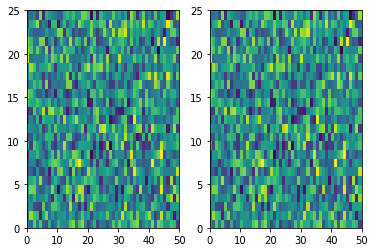

In [21]:
plt.subplot(1,2,1)
plt.pcolor(c)
plt.subplot(1,2,2)
plt.pcolor(a+b)
